## Data Loading and Preprocessing

In [10]:
from pathlib import Path
import re
import string
import pandas as pd
from sklearn.model_selection import train_test_split


def load_data(path: Path) -> pd.DataFrame:
    data = pd.read_csv(path)
    data = pd.DataFrame(
        {
            "job_description": data[
                ["company_profile", "description", "requirements", "benefits"]
            ]
            .fillna("")
            .agg(" ".join, axis=1),
            "fraudulent": data["fraudulent"],
        }
    )
    data = data.drop_duplicates(subset=["job_description"], keep="first")
    return data

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def split_data(data: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(
        data["job_description"],
        data["fraudulent"],
        test_size=0.2,
        random_state=42,
        stratify=data["fraudulent"],
    )

    # Convert to DataFrame for easy manipulation
    train_df = pd.DataFrame({'job_description': X_train, 'fraudulent': y_train})

    # Separate fraudulent (y=1) and non-fraudulent (y=0) samples
    fraudulent_df = train_df[train_df['fraudulent'] == 1]
    non_fraudulent_df = train_df[train_df['fraudulent'] == 0]
    print(fraudulent_df.shape, non_fraudulent_df.shape)

    # Oversample each fraudulent job description exactly 21 times
    fraudulent_df_oversampled = pd.concat([fraudulent_df] * 21, ignore_index=True)

    # Combine the oversampled fraudulent data with the original non-fraudulent data
    train_df_oversampled = pd.concat([non_fraudulent_df, fraudulent_df_oversampled], ignore_index=True)

    # Shuffle the data
    train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract the oversampled X_train and y_train
    X_train: pd.Series[str] = train_df_oversampled['job_description']
    y_train: pd.Series[int] = train_df_oversampled['fraudulent']

    # apply clean_text function to the training and test data

    X_train = X_train.apply(clean_text)
    X_test = X_test.apply(clean_text)

    return X_train, X_test, y_train, y_test


## Download the Dataset from Kaggle

In [11]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
print("Path to dataset files:", path)

data = load_data(Path(path + "/fake_job_postings.csv"))

X_train, X_test, y_train, y_test = split_data(data)

print(X_train.head())
print(y_train.head())

Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1
(547, 2) (11832, 2)
0     in trading is a vertically integrated solid w...
1    we believe cities are complicated and your mob...
2    smarter good is an innovative global services ...
3    join the your phone connect team and earn mone...
4    at total eclipse we create fun original and ad...
Name: job_description, dtype: object
0    0
1    0
2    0
3    1
4    0
Name: fraudulent, dtype: int64


## Define the Dataset loader

In [12]:
from torch.utils.data import Dataset
import torch

class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        Args:
            texts (pd.Series or list): The job descriptions.
            labels (pd.Series or list): The corresponding labels (0 or 1).
            tokenizer (PreTrainedTokenizer): Tokenizer for BERT.
            max_length (int): Maximum token length for each text.
        """
        # Convert pandas Series to list if needed
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.labels = labels.tolist() if hasattr(labels, 'tolist') else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        # Tokenize the text with truncation and padding
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Squeeze to remove the batch dimension
        encoding = {key: tensor.squeeze(0) for key, tensor in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        return encoding

In [13]:
base_model_name = "bert-large-uncased"

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_dataset = JobDataset(X_train, y_train, tokenizer, max_length=512)
test_dataset = JobDataset(X_test, y_test, tokenizer, max_length=512)


In [15]:
from transformers import AutoModelForSequenceClassification

classification_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import wandb
from google.colab import userdata


wandb.login(key=userdata.get('wandb'))

# Set up training arguments
training_args = TrainingArguments(
    run_name="bert",
    output_dir='./results',             # output directory
    num_train_epochs=1,                 # total number of training epochs
    per_device_train_batch_size=16,     # batch size per device during training
    per_device_eval_batch_size=16,      # batch size for evaluation
    eval_strategy='epoch',        # evaluate at the end of each epoch
    save_strategy='epoch',              # save checkpoint at the end of each epoch
    logging_dir='./logs',               # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,        # load the best model when finished training
    metric_for_best_model="accuracy",   # use accuracy to evaluate the best model
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


# Initialize the Trainer
trainer = Trainer(
    model=classification_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pclouduwu (pclouduwu-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 24.12 MiB is free. Process 4520 has 14.71 GiB memory in use. Of the allocated memory 14.50 GiB is allocated by PyTorch, and 96.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2958
           1       0.84      0.78      0.81       137

    accuracy                           0.98      3095
   macro avg       0.92      0.89      0.90      3095
weighted avg       0.98      0.98      0.98      3095



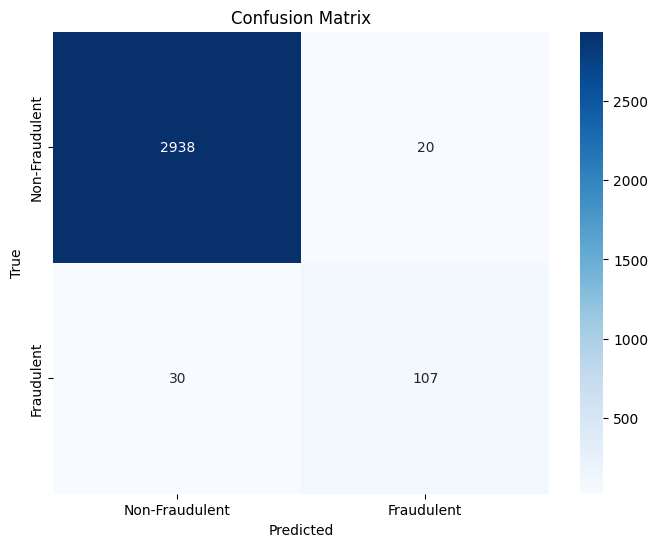

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Get predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Evaluate with per-class precision, recall, F1-score
print(classification_report(y_test, predicted_labels))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraudulent", "Fraudulent"],
            yticklabels=["Non-Fraudulent", "Fraudulent"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Save model to Hugging Face

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

repo = "pcloud/job_catcher-bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_bert")

model.push_to_hub(repo)
tokenizer.push_to_hub(repo)

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pcloud/job_catcher-bert-base-uncased/commit/359edfd736108f7494a260a899009ed5e5d60bb4', commit_message='Upload tokenizer', commit_description='', oid='359edfd736108f7494a260a899009ed5e5d60bb4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pcloud/job_catcher-bert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='pcloud/job_catcher-bert-base-uncased'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Replace with your uploaded model name
model_name = repo

# Load model and tokenizer from Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

def predict(job_text, model, tokenizer):
    inputs = tokenizer(
        job_text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()  # 0 = Real, 1 = Fake
    return "Fake Job Posting" if prediction == 1 else "Real Job Posting"

# Example usage:
new_job_posting = "Alliance is looking for people who are passionate about both the work they do and the life they live.We are a high energy, goal oriented organization who is seeking out like minded professionals to assist our organization in continued growth. Alliance is an industry leader in providing innovative point-of-sale (POS) payment acceptance capabilities -- and backing them up with service, financial strength and stability.We offer flexibility, uncapped success, autonomy and life/work balance.You would be hard pressed to find a company that will treat you better. We offer daily/monthly contests and yearly bonuses for top employees. Come see why AMS is one of the fastest growing companies."
result = predict(new_job_posting, model, tokenizer)
result


'Fake Job Posting'